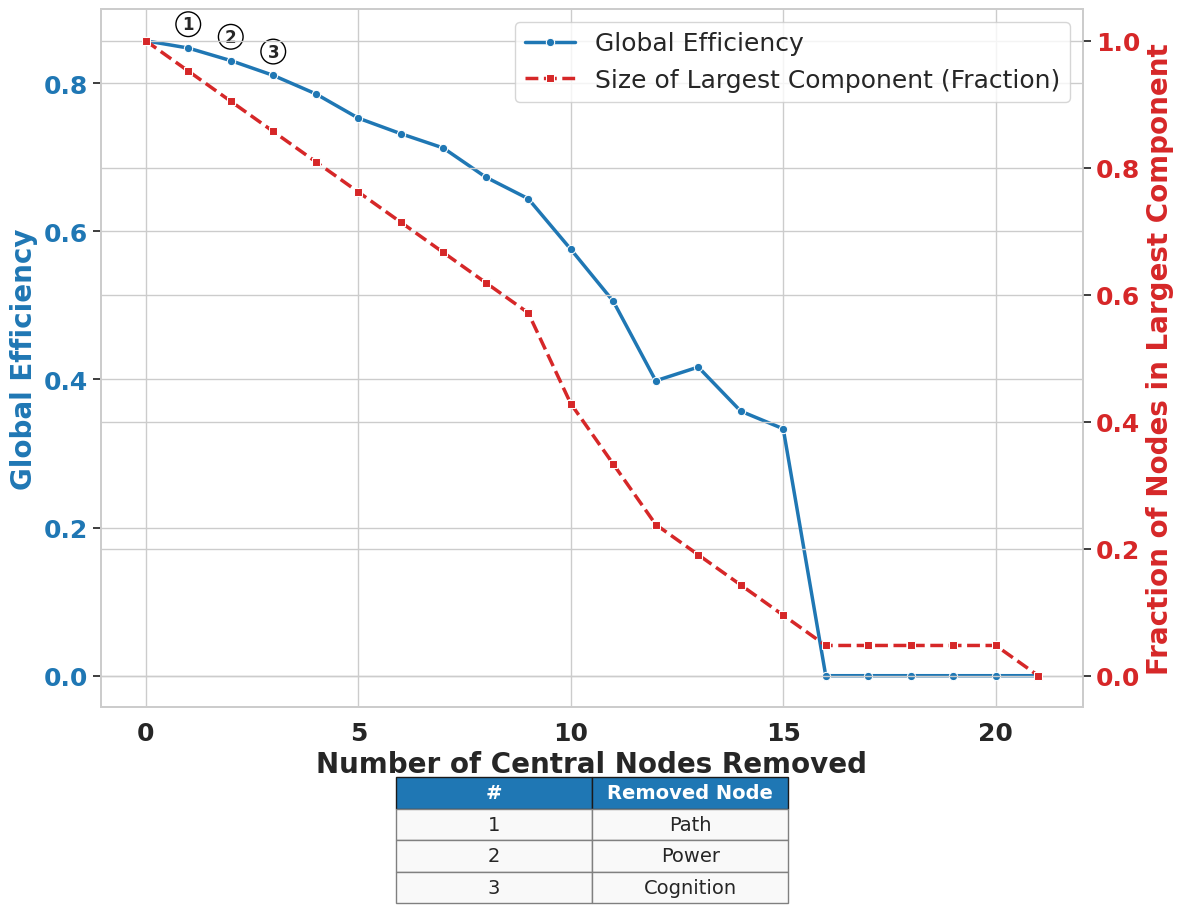

In [ ]:
#@title  **Network Robustness to Targeted Node Removal**


# --- [الخطوة 0: التثبيت والاستيراد] ---
!git clone https://github.com/NoorBayan/Amthal.git
%cd Amthal
from utility import *
from IPython.display import display, HTML, clear_output


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import io
from itertools import combinations



# --- [الخطوة 1: تحميل وتجهيز البيانات] ---
print("--- [Step 1: Loading Data] ---")
# ⚠️⚠️⚠️  الرجاء التأكد من أن هذا المسار صحيح في بيئتك
INSTANCES_FILE_PATH = '/content/Amthal/data/processed/instances.csv'
try:
    df = pd.read_csv(INSTANCES_FILE_PATH, sep='\t', encoding='utf-16')
    df['Dominant_Concept']=[Dominant_Concept_dic[i]['en'] for i in df.Dominant_Concept]

    print(f"Data loaded successfully. Found {len(df)} instances.\n")
except FileNotFoundError:
    print(f"⚠️ ERROR: File not found at '{INSTANCES_FILE_PATH}'. Please check the path and try again.")
    exit()


# --- 2. بناء الشبكة الأصلية وحساب أهمية العقد ---
grouped = df.groupby(['Sura_No', 'Aya_No'])['Dominant_Concept'].apply(list)
edges = [tuple(sorted(combo)) for concepts in grouped if len(concepts) > 1 for combo in combinations(set(concepts), 2)]
edge_weights = pd.DataFrame(edges, columns=['source', 'target']).value_counts().reset_index(name='weight')
G_original = nx.from_pandas_edgelist(edge_weights, 'source', 'target', ['weight'])

# سنقوم بإزالة العقد بناءً على درجة المركزية الموزونة (أو يمكنك استخدام Betweenness)
degrees = dict(G_original.degree(weight='weight'))
# فرز العقد من الأكثر أهمية إلى الأقل أهمية
nodes_to_remove = sorted(degrees, key=degrees.get, reverse=True)


# --- 3. إجراء محاكاة الإزالة (Simulation) ---
# سنقوم بتخزين النتائج في قائمة
simulation_results = []

# حساب المقاييس الأولية للشبكة الكاملة
G_current = G_original.copy()
initial_efficiency = nx.global_efficiency(G_current)
largest_comp = max(nx.connected_components(G_current), key=len)
initial_lcc_size = len(largest_comp)

simulation_results.append({
    'nodes_removed_count': 0,
    'removed_node': 'None',
    'global_efficiency': initial_efficiency,
    'lcc_size_fraction': 1.0 # 100% في البداية
})

# حلقة لإزالة العقد واحدة تلو الأخرى
for i, node in enumerate(nodes_to_remove):
    G_current.remove_node(node)

    # حساب المقاييس بعد الإزالة
    # يجب التحقق من أن الشبكة لا تزال تحتوي على عقد
    if G_current.number_of_nodes() > 0:
        # حساب الكفاءة (يتطلب أن تكون الشبكة متصلة، لذا سنتعامل مع المكونات)
        # نحسب الكفاءة لكل مكون ونأخذ المتوسط الموزون
        total_efficiency = 0
        components = list(nx.connected_components(G_current))
        if components:
            for comp in components:
                subgraph = G_current.subgraph(comp)
                total_efficiency += nx.global_efficiency(subgraph) * len(comp)
            efficiency = total_efficiency / G_current.number_of_nodes()

            # حساب حجم أكبر مكون متبقي
            largest_comp = max(components, key=len)
            lcc_size = len(largest_comp)
        else: # إذا أصبحت الشبكة فارغة تمامًا
            efficiency = 0
            lcc_size = 0
    else:
        efficiency = 0
        lcc_size = 0

    simulation_results.append({
        'nodes_removed_count': i + 1,
        'removed_node': node,
        'global_efficiency': efficiency,
        'lcc_size_fraction': lcc_size / initial_lcc_size
    })

# تحويل النتائج إلى DataFrame
results_df = pd.DataFrame(simulation_results)



# --- 4. إعداد الرسم البياني الاحترافي ---
sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 10))


# الرسم البياني الأول (Global Efficiency)
sns.lineplot(
    data=results_df,
    x='nodes_removed_count',
    y='global_efficiency',
    color='#1f77b4',        # أزرق أكاديمي
    marker='o',
    linewidth=2.5,
    label='Global Efficiency',
    ax=ax1
)
ax1.set_xlabel('Number of Central Nodes Removed', fontsize=20, fontweight='bold')
ax1.set_ylabel('Global Efficiency', color='#1f77b4', fontsize=20, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#1f77b4')

# الرسم البياني الثاني (Largest Component Fraction)
ax2 = ax1.twinx()
sns.lineplot(
    data=results_df,
    x='nodes_removed_count',
    y='lcc_size_fraction',
    color='#d62728',        # أحمر أكاديمي
    marker='s',
    linewidth=2.5,
    linestyle='--',
    label='Size of Largest Component (Fraction)',
    ax=ax2
)
ax2.set_ylabel('Fraction of Nodes in Largest Component', color='#d62728', fontsize=20, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#d62728')


# --- 👇 أضف هذا المقطع هنا 👇 ---
ax1.tick_params(axis='both', labelsize=18)
ax2.tick_params(axis='both', labelsize=18)
plt.setp(ax1.get_xticklabels(), fontweight='bold')
plt.setp(ax1.get_yticklabels(), fontweight='bold')
plt.setp(ax2.get_yticklabels(), fontweight='bold')
# --- 👆 انتهى المقطع الإضافي 👆 ---


# --- 5. إضافة التحسينات ---
#fig.suptitle('Figure 3a: Network Robustness to Targeted Node Removal', fontsize=20, fontweight='bold')

for i in range(1, 4):
    ax1.annotate(str(i),
                 xy=(i, results_df.loc[i, 'global_efficiency']),
                 xytext=(i, results_df.loc[i, 'global_efficiency'] + 0.02),
                 ha="center", va="bottom",
                 fontsize=12, fontweight="bold",
                 bbox=dict(boxstyle="circle,pad=0.2", fc="white", ec="black"))


# إنشاء جدول صغير أسفل المخطط بالأسماء الكاملة (أنيق وصغير)
table_data = [
    ["1", results_df.loc[1, "removed_node"]],
    ["2", results_df.loc[2, "removed_node"]],
    ["3", results_df.loc[3, "removed_node"]],
]

the_table = plt.table(
    cellText=table_data,
    colLabels=["#", "Removed Node"],
    cellLoc='center',
    loc='bottom',
    bbox=[0.3, -0.28, 0.4, 0.18]  # أصغر من السابق
)

# تحسين مظهر الجدول
the_table.auto_set_font_size(False)
the_table.set_fontsize(14)  # خط أصغر
the_table.scale(1, 1.2)     # تحكم في ارتفاع الصفوف

# جعل الرؤوس غامقة بخلفية خفيفة
for (row, col), cell in the_table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#1f77b4')  # أزرق أكاديمي للرؤوس
    else:
        cell.set_facecolor('#f9f9f9')  # خلفية فاتحة للبيانات
        cell.set_edgecolor('gray')

# --- دمج الأساطير (Legends) ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=18)
ax1.get_legend().remove()  # إزالة legend المحور الأول (لتفادي التكرار)


# --- 6. الحفظ والعرض ---
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Robustness_Analysis.png', dpi=300, bbox_inches='tight')
clear_output()
plt.show()


